# The Coffee Cup Caustic - Analytic and Numeric

>In optics, a caustic is a curve of concentrated light, defined as the envelope of light rays reflected by a curved surface.A familiar caustic is the rainbow but another commonly observed example is the coffeecup caustic, which is the light pattern created on the top of a cup of coffee by strong light reflecting off the inside of the cup.

> -- [Grace Weir](http://www.graceweir.com/page31/page31.html)

In this context we analyze parallel rays hitting a half-circle, and compute analytically and numerically the caustic

## Setup

In [1]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.colors as colors

We assume the center of the half-circle is the origin. We also assume the radius is 1. For simplicity we also assume the lines do not hit the half-cirle at its endpoints ($x=-1,1$), since at these points the curve is not differentiable and the reflection is ill-defined.

All lines are in the direction $-\hat{y}$, so they are defined by equations $x=t, y \in \mathbb{R}$, where $t$ is a parameter in the open range $(-1,1)$.

We define the required number of lines and compute the corresponding values of $t$:

In [15]:
N = 100
t = np.linspace(-1,1,N+2)
t = t[1:-1]

The intersections points are when the lines reach the half-circle, i.e. when their coordinates fulfill $x^2+y^2=1, y<0$. We substitue $x=t$ and choose the negative solution and get $y=-\sqrt{1-x^2}$. The intersections points are thus:

$(x, y) = (t, -\sqrt{1-x^2}), t\in (-1,1)$

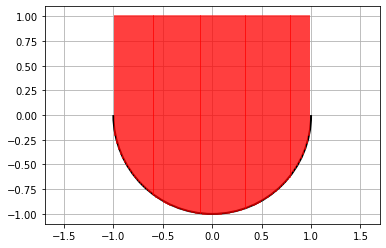

In [16]:
from matplotlib import patches
x_intersect = t
y_intersect = -np.sqrt(1-t**2)
y_beg = np.ones(y_intersect.shape)
fig = plt.figure()
ax = fig.add_subplot(111)

e1 = patches.Arc((0,0), width=2, height=2, theta1=180.0, theta2=360.0, linewidth=2, fill=False, zorder=2)
ax.add_patch(e1)

for jj in range(0,x_intersect.size):
    plt.plot([x_intersect[jj], x_intersect[jj]], [y_beg[jj], y_intersect[jj]], 'r-')

plt.xlim((-1.5,1.5))
plt.ylim((-1.5,0))
plt.axis('equal')
plt.grid(True)
plt.show()

Now we compute the direction of the reflected rays. According to the law of reflection the angle of incidence is equal to the angle of reflection, i.e. symmetric to the curve normal vector. 

We could use vector linear algebra to get the result, but in this case the axis of symmetry is trivially the direction to the center of the circle, i.e. the angle of the intersect point reversed. Moreover, the angle between the incident (original) ray and the $x$-axis is always $\pi/2$.

We can then simply compute the angle between the reflected ray and the $x$-axis with $\theta_{reflected}= 2\theta-\pi/2$, where $\theta$ is the angle of the normal of the circle pointing inwards. Note that we can express the intersect points on the half-circle as a function of $\theta$ : $(x,y)=(-\cos{\theta},-\sin{\theta})$.

In [17]:
normal_angles = (np.arctan2(-y_intersect,-x_intersect)) #negated
incident_angles = np.pi/2 * np.ones(normal_angles.shape)
reflected_angles = (2*normal_angles) - incident_angles

We represent the reflected rays as lines with equation of the form $y=mx+b$, except for a special case we will detail later. From simple trigonometry, if $\theta \neq \pi/2$, this gives the coefficient $m=tan(\theta_{reflected})=tan(2\theta-\pi/2)=-1/tan(2\theta)$. We substitute back to the line equation to get the intercept $b=y_i-m \cdot x_i=-sin(\theta) - cos(\theta)/tan(2\theta)$.

If $\theta =\pi/2$, the equation of the line is $x=0$. In the code we deal with this case in the plotting only.

In [18]:
reflected_coeff =-1/np.tan(2*normal_angles) #np.tan(reflected_angles)
reflected_intersect = -np.sin(normal_angles)-np.cos(normal_angles)/np.tan(2*normal_angles) # y_intersect - x_intersect *reflected_coeff 
new_x = -np.sign(x_intersect)*0
new_y = reflected_coeff * new_x + reflected_intersect

We plot, together with the normal vectors:

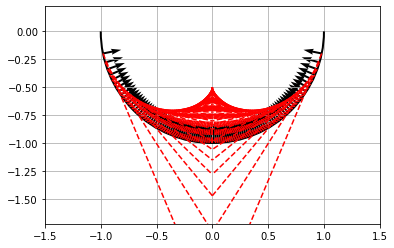

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
e1 = patches.Arc((0,0), width=2, height=2, theta1=180.0, theta2=360.0, linewidth=2, fill=False, zorder=2)
ax.add_patch(e1)
for jj in range(0,x_intersect.size):
    if abs(x_intersect[jj])>(1.0/N):
        plt.plot([x_intersect[jj], new_x[jj]], [y_intersect[jj], new_y[jj]], 'r--')
    else:
        plt.plot([0, 0], [-1, -0.5], 'r--')

plt.quiver(x_intersect, y_intersect, -x_intersect, -y_intersect)
plt.axis('equal')
plt.xlim((-1.5,1.5))
plt.ylim((-1.5,0))
plt.grid(True)
plt.show()

## Envelope - numeric solution

We can approximately compute the caustic completely numerically, by computing many values along the lines and differentiating according to $t$. See below the derivative computations and display:

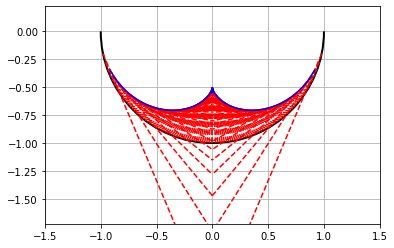

In [20]:
number_of_pts = 1000
xs = np.tile(np.linspace(-1,1,number_of_pts), (t.size,1))
m_mat = np.tile(reflected_coeff, (number_of_pts,1)).T
b_mat = np.tile(reflected_intersect, (number_of_pts,1)).T
ys = m_mat * xs + b_mat
dydt = np.diff(ys,axis=0)
kk_zero = np.argmin(abs(dydt),axis=1)

def choose(selector, choices):
    """
    A simplified version of the numpy choose function to workaround the 32
    choices limit.
    """
    return np.array([choices[selector[idx]][idx] for idx in np.lib.index_tricks.ndindex(selector.shape)]).reshape(selector.shape)


caustic_numeric_x = choose(kk_zero, xs[0:-1,:].T)
caustic_numeric_y = choose(kk_zero, ys[0:-1,:].T)

fig = plt.figure()
ax = fig.add_subplot(111)
e1 = patches.Arc((0,0), width=2, height=2, theta1=180.0, theta2=360.0, linewidth=2, fill=False, zorder=2)
ax.add_patch(e1)
for jj in range(0,x_intersect.size):
    if abs(x_intersect[jj])>(1.0/N):
        plt.plot([x_intersect[jj], new_x[jj]], [y_intersect[jj], new_y[jj]], 'r--')
    else:
        plt.plot([0, 0], [-1, -0.5], 'r--')

plt.plot(caustic_numeric_x, caustic_numeric_y, '-b')
plt.axis('equal')
plt.xlim((-1.5,1.5))
plt.ylim((-1.5,0))
plt.grid(True)
plt.show()

This gives okay results, but the accuracy and range depends directly on the number of simulated rays and the number of points computed along the lines.

Also note that there is a small error around $x=0$, because in our reprentation this is a special case and differentiating $y$ will give infinite derivative. However adding points makes this problem negligible.

## Envelope - analytic solution

We can also find analytically the equation of the caustic.

We have shown that the equation of the $\theta$-parametric family of the reflected rays is:

$$
y-m \cdot x-b=0 \\
\Leftrightarrow \frac{x}{tan(2\theta)} + y + sin(\theta) + \frac{cos(\theta)}{tan(2\theta)}=0 \\
$$

We multiply both side by $sin(2\theta)$ and we get:

$$
cos(2\theta) \cdot x + sin(2\theta) \cdot y + sin(\theta)sin(2\theta) + cos(\theta)cos(2\theta)=0
$$

Using the trigonometric identity $cos(\alpha-\beta)=cos(\alpha)cos(\beta)+sin(\alpha)sin(\beta)$, we get:

$$
cos(2\theta) \cdot x + sin(2\theta) \cdot y + cos(\theta)=0
$$

According to definition of the envelope we compute the derivative according to $\theta$ and enforce its equality to zero:

$$
\begin{cases} 
cos(2\theta) \cdot x + sin(2\theta) \cdot y + cos(\theta)=0 \\ 
-2sin(2\theta) \cdot x + 2cos(2\theta) \cdot y - sin(\theta)=0 
\end{cases} \\
$$

Which gives:

$$
\Leftrightarrow 
\begin{bmatrix}
cos(2\theta) & sin(2\theta) \\
-2sin(2\theta) & 2cos(2\theta)
\end{bmatrix}
\begin{bmatrix}
x\\y
\end{bmatrix}
=
\begin{bmatrix}
-cos(\theta)\\
sin(\theta)
\end{bmatrix}
$$

We inverse the matrix:

$$
\begin{bmatrix}
cos(2\theta) & sin(2\theta) \\
-2sin(2\theta) & 2cos(2\theta)
\end{bmatrix}^{-1}
=
\frac{1}{cos(2\theta)2cos(2\theta) - sin(2\theta)(-2sin(2\theta))}
\begin{bmatrix}
2cos(2\theta) & -sin(2\theta) \\
2sin(2\theta) & cos(2\theta)
\end{bmatrix}
$$

And we get:

$$
\begin{bmatrix}
x\\y
\end{bmatrix}
=
\frac{1}{2}
\begin{bmatrix}
2cos(2\theta) & -sin(2\theta) \\
2sin(2\theta) & cos(2\theta)
\end{bmatrix}
\begin{bmatrix}
-cos(\theta)\\
sin(\theta)
\end{bmatrix}
$$

Further simplification of the expressions can be found in  Brian J. Loe & Nathaniel Beagley (1997), "The Coffee Cup Caustic for Calculus Students", The College Mathematics Journal, 28:4, 277-284.  Note they used a more complicated way to obtain the results.

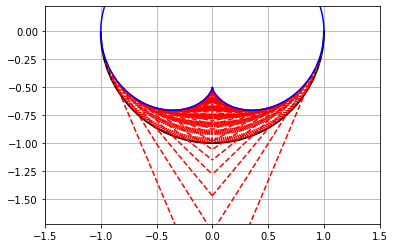

In [21]:
theta = np.linspace(0,2*np.pi,1000)
caustic_x = -0.5 * (2*np.cos(theta)*np.cos(2*theta) + np.sin(theta)*np.sin(2*theta))
caustic_y = 0.5*(-2*np.cos(theta)*np.sin(2*theta) + np.cos(2*theta)*np.sin(theta))

fig = plt.figure()
ax = fig.add_subplot(111)
e1 = patches.Arc((0,0), width=2, height=2, theta1=180.0, theta2=360.0, linewidth=2, fill=False, zorder=2)
ax.add_patch(e1)
for jj in range(0,x_intersect.size):
    if abs(x_intersect[jj])>(1.0/N):
        plt.plot([x_intersect[jj], new_x[jj]], [y_intersect[jj], new_y[jj]], 'r--')
    else:
        plt.plot([0, 0], [-1, -0.5], 'r--')
plt.plot(-caustic_x, -caustic_y, '-b')
plt.axis('equal')
plt.xlim((-1.5,1.5))
plt.ylim((-1.5,0))
plt.grid(True)
plt.show()